# RAG System Development Workflow

This notebook guides you through the step-by-step development and optimization of the RAG (Retrieval-Augmented Generation) system for the Multi-modal Enterprise KM Agent, leveraging our modular architecture of **building blocks** (low-level utilities) and **streamlined components** (higher-level orchestrators).

The workflow is divided into four phases:
- **Phase 1**: Knowledge Base Construction (using `indexing_pipeline.py` streamlined component)
- **Phase 2**: LoRA Fine-Tuning (using `lora_manager.py` and `lora_finetuner.py` streamlined components)
- **Phase 3**: Benchmarking (using `experiment_manager.py` streamlined component)
- **Phase 4**: Iterative Optimization

Each phase demonstrates integration of building blocks (e.g., `text_chunker.py`, `embedding.py`) within streamlined components for robust, scalable workflows.

In [1]:
# Import required libraries
import os
import sys
import logging
from dotenv import load_dotenv

# Load environment variables from .env file BEFORE any other imports
load_dotenv(dotenv_path='../.env')

sys.path.append('../src')
from pathlib import Path
from datasets import load_dataset
from src.rag.components import get_indexing_pipeline
from tqdm import tqdm


# Suppress INFO logs from libraries and components
logging.getLogger().setLevel(logging.WARNING)

# Set paths from environment variables with defaults
# Use absolute path resolution to ensure we're always in the project root
notebook_dir = Path().resolve()
if notebook_dir.name == 'notebooks':
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

project_root = Path(os.getenv('PROJECT_ROOT', str(project_root))).resolve()
raw_data_dir = Path(os.getenv('RAW_DATA_DIR', str(project_root / 'data' / 'raw')))
processed_data_dir = Path(os.getenv('PROCESSED_DATA_DIR', str(project_root / 'data' / 'processed')))
vector_db_path = Path(os.getenv('CHROMA_PERSIST_DIR', str(project_root / 'chroma_db')))

# Dataset configuration
dataset_name = "wikitext"  # Change this for different datasets
data_subdir = raw_data_dir / dataset_name
data_subdir.mkdir(parents=True, exist_ok=True)

# Explicitly set MLflow tracking directory to root mlruns
mlruns_path = Path(os.getenv('MLRUNS_DIR', str(project_root / 'mlruns'))).resolve()
print(f"Using MLflow tracking directory: {mlruns_path}")
print(f"Project root: {project_root}")

/opt/homebrew/Caskroom/miniconda/base/envs/mmagent/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MLflow tracking directory: /Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent/mlruns
Project root: /Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent


## Phase 1: Knowledge Base Construction

In this phase, we build the vector database from a Wikipedia subset using the `indexing_pipeline.py` streamlined component, which orchestrates:
- **Building blocks**: `document_parser.py` (for TXT parsing), `text_chunker.py` (for chunking), `embedding.py` (for vector generation), `vector_database.py` (for storage).
- Process: Download → Parse → Chunk → Embed → Store in ChromaDB.

This demonstrates how streamlined components integrate building blocks into an end-to-end workflow.

In [2]:
# Check if data already exists
existing_files = list(data_subdir.glob('*.txt')) if data_subdir.exists() else []
if existing_files:
    documents = existing_files
    print(f"Found {len(documents)} existing passages in {dataset_name}. Skipping download.")
else:
    try:
        # Download Wikipedia subset (using WikiText as a Wikipedia-derived dataset)
        print(f"Downloading {dataset_name} subset...")
        dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train[:5000]")  # First 5000 passages

        # Save articles to text files in subfolder
        documents = []
        for i, article in tqdm(enumerate(dataset), desc="Saving articles"):
            text = article['text'].strip()
            if text:  # Only save non-empty passages
                file_path = data_subdir / f"article_{i}.txt"
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(text)
                documents.append(file_path)

        print(f"Downloaded and saved {len(documents)} non-empty passages to {dataset_name}.")
    except Exception as e:
        print(f"Failed to download or save dataset: {e}")
        documents = []

Found 3227 existing passages in wikitext. Skipping download.


In [3]:
# Check for already indexed documents
indexing_pipeline = get_indexing_pipeline(db_path=str(vector_db_path))
already_indexed = set()
try:
    # Query existing documents in the DB (assuming metadata has 'file_path')
    existing_docs = indexing_pipeline.db.get(include=['metadatas'])
    for metadata in existing_docs.get('metadatas', []):
        if 'file_path' in metadata:
            already_indexed.add(metadata['file_path'])
except Exception as e:
    print(f"Could not check existing documents: {e}. Proceeding with indexing.")

2025/10/09 13:29:44 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/09 13:29:44 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/10/09 13:29:44 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [4]:
# Filter out already indexed documents
documents_to_index = [doc for doc in documents if str(doc) not in already_indexed]

if not documents_to_index:
    print("All documents already indexed. Skipping indexing.")
else:
    print(f"Indexing {len(documents_to_index)} new documents...")
    try:
        # Convert Path objects to strings and index all documents in batch
        file_paths = [str(doc) for doc in documents_to_index]
        indexing_pipeline.index_documents_batch(file_paths, 
                                                batch_size=64, 
                                                num_workers=4)
        print("Knowledge base updated successfully.")
    except Exception as e:
        print(f"Failed to index documents: {e}")

All documents already indexed. Skipping indexing.


## Phase 1: Test Knowledge Base Retrieval

After indexing, test the knowledge base using the `retriever.py` streamlined component (which uses `embedding.py` and `vector_database.py` building blocks) and the full `rag_pipeline.py` streamlined component for end-to-end Q&A.

In [5]:
# Test retrieval using retriever
from src.rag.retriever import get_retriever

retriever = get_retriever(db_path=str(vector_db_path))
test_query = "What is artificial intelligence?"
results = retriever.retrieve(test_query, top_k=3)
print(f"Query: {test_query}")
for i, result in enumerate(results):
    print(f"Result {i+1}: {result['document'][:200]}...")


Query: What is artificial intelligence?
Result 1: = forward intelligence team =...
Result 2: = = information processing = =...
Result 3: = = = planning system = = =...


In [6]:
# Test full RAG pipeline
os.environ['QUANT_TYPE'] = "dynamic"

from src.rag.components import get_rag_pipeline

pipeline = get_rag_pipeline(db_path=str(vector_db_path))
response = pipeline.answer_question(test_query)
print(f"\nRAG Answer: {response['answer']}")
print(f"Context docs used: {len(response['context_docs'])}")
print(f"Metadata: {response['metadata']}")


RAG Answer: planning system
Context docs used: 5
Metadata: {'retrieval_latency_ms': 70.15609741210938, 'generation_latency_ms': 590.0380611419678, 'total_latency_ms': 660.2151393890381, 'retrieved_docs_count': 5}


## Phase 1: Prepare Training Data for LoRA

Prepare the Dolly-15k-mini dataset for LoRA fine-tuning using the `lora_finetuner.py` streamlined component. This involves formatting data as instruction-response pairs, leveraging building blocks like dataset loading and preprocessing for scalable data preparation.

In [7]:
# Import libraries
from datasets import load_dataset

# Set paths
project_root = Path(os.getenv('PROJECT_ROOT', '..')).resolve()

# Set dataset path
processed_data_dir = Path(os.getenv('PROCESSED_DATA_DIR', str(project_root / 'data' / 'processed')))
processed_data_dir.mkdir(parents=True, exist_ok=True)
dataset_path = processed_data_dir / 'dolly_formatted.json'

# Load Dolly-15k-mini dataset
dataset = load_dataset('databricks/databricks-dolly-15k', split='train[:1000]')  # Small subset for demo

# Format as instruction-response pairs
def format_instruction_response(example):
    return {
        'instruction': example['instruction'],
        'response': example['response']
    }

formatted_dataset = dataset.map(format_instruction_response)

# Save formatted dataset
formatted_dataset.save_to_disk(str(dataset_path))
print(f"Prepared and saved {len(formatted_dataset)} training examples to {dataset_path}.")

Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 250361.37 examples/s]

Prepared and saved 1000 training examples to /Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent/data/processed/dolly_formatted.json.


## Phase 2: Set Up LoRA Training Infrastructure

Initialize the LoRA training setup using the `lora_manager.py` streamlined component (`LoRAConfigManager`), which integrates building blocks like model loading and quantization for efficient fine-tuning on M1 Pro.

In [8]:
from src.rag.managers.lora_manager import LoRAConfigManager
import os
from datasets import load_from_disk
from peft import LoraConfig

# Set paths from environment variables
project_root = Path(os.getenv('PROJECT_ROOT', '..')).resolve()
model_configs_path = Path(os.getenv('MODEL_CONFIGS_DIR', str(project_root / 'model_configs')))
model_configs_path.mkdir(parents=True, exist_ok=True)

# Initialize LoRA manager with GPT-2 compatible config
lora_manager = LoRAConfigManager(
    base_model_path='microsoft/DialoGPT-medium',
    adapter_save_path=str(model_configs_path)
)

# Load base model
model, tokenizer = lora_manager.load_base_model()

# Inspect model structure to find correct target modules
print("Inspecting model modules for LoRA targets...")
for name, module in model.named_modules():
    if 'attn' in name.lower() or 'proj' in name.lower():
        print(f"  {name}: {type(module).__name__}")

# Apply LoRA with GPT-2 compatible target modules
# For GPT-2/DialoGPT, target the attention and projection layers
gpt2_lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn", "c_proj"],  # GPT-2 attention modules
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = lora_manager.apply_lora(lora_config=gpt2_lora_config)

# Load dataset
processed_data_dir = Path(os.getenv('PROCESSED_DATA_DIR', str(project_root / 'data' / 'processed')))
dataset_path = processed_data_dir / 'dolly_formatted.json'

if dataset_path.exists():
    print(f"Loading dataset from {dataset_path}...")
    train_dataset = load_from_disk(str(dataset_path))
    print(f"Loaded {len(train_dataset)} training examples")
else:
    print(f"Dataset not found at {dataset_path}. Please run the dataset preparation cell first.")
    train_dataset = None

# Make dataset available for next cell
if train_dataset is not None:
    print("Dataset loaded successfully and ready for training.")
else:
    print("Please prepare the dataset first before proceeding with training.")

Inspecting model modules for LoRA targets...
  transformer.h.0.attn: GPT2Attention
  transformer.h.0.attn.c_attn: Conv1D
  transformer.h.0.attn.c_proj: Conv1D
  transformer.h.0.attn.attn_dropout: Dropout
  transformer.h.0.attn.resid_dropout: Dropout
  transformer.h.0.mlp.c_proj: Conv1D
  transformer.h.1.attn: GPT2Attention
  transformer.h.1.attn.c_attn: Conv1D
  transformer.h.1.attn.c_proj: Conv1D
  transformer.h.1.attn.attn_dropout: Dropout
  transformer.h.1.attn.resid_dropout: Dropout
  transformer.h.1.mlp.c_proj: Conv1D
  transformer.h.2.attn: GPT2Attention
  transformer.h.2.attn.c_attn: Conv1D
  transformer.h.2.attn.c_proj: Conv1D
  transformer.h.2.attn.attn_dropout: Dropout
  transformer.h.2.attn.resid_dropout: Dropout
  transformer.h.2.mlp.c_proj: Conv1D
  transformer.h.3.attn: GPT2Attention
  transformer.h.3.attn.c_attn: Conv1D
  transformer.h.3.attn.c_proj: Conv1D
  transformer.h.3.attn.attn_dropout: Dropout
  transformer.h.3.attn.resid_dropout: Dropout
  transformer.h.3.mlp.c_

/opt/homebrew/Caskroom/miniconda/base/envs/mmagent/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Loading dataset from /Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent/data/processed/dolly_formatted.json...
Loaded 1000 training examples
Dataset loaded successfully and ready for training.


## Phase 2: Execute LoRA Fine-Tuning

Run LoRA fine-tuning using the `lora_finetuner.py` streamlined component, which handles training orchestration, dataset loading, and adapter management. This builds on the setup from the previous cell and actually performs the fine-tuning to create a trained adapter.

In [9]:
# Execute LoRA Fine-Tuning
from src.rag.components import get_lora_finetuner

# Set up fine-tuner
finetuner = get_lora_finetuner()

# Check if adapter already exists
adapter_path = model_configs_path / 'lora_adapters' / 'microsoft' / 'DialoGPT-medium' / 'lora_adapter'
if adapter_path.exists():
    print(f"LoRA adapter already exists at {adapter_path}")
    print("Skipping fine-tuning to avoid overwriting existing adapter.")
    success = True
else:
    print(f"Adapter not found at {adapter_path}")
    print("Starting LoRA fine-tuning...")

    # Run the complete fine-tuning pipeline
    # Note: Optimal LoRA config is automatically selected based on model architecture
    success = finetuner.finetune_pipeline(
        model_name='microsoft/DialoGPT-medium',
        dataset_path=str(processed_data_dir / 'dolly_formatted.json'),
        adapter_name='lora_adapter',
        training_config={
            "num_epochs": 1,  # Quick training for demo
            "batch_size": 2,
            "learning_rate": 5e-5,
            "max_length": 512
        }
    )

if success:
    print("LoRA fine-tuning completed successfully!")
    print(f"Fine-tuned adapter available at {adapter_path}")
else:
    print("LoRA fine-tuning failed. Check logs for details.")

LoRA adapter already exists at /Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent/model_configs/lora_adapters/microsoft/DialoGPT-medium/lora_adapter
Skipping fine-tuning to avoid overwriting existing adapter.
LoRA fine-tuning completed successfully!
Fine-tuned adapter available at /Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent/model_configs/lora_adapters/microsoft/DialoGPT-medium/lora_adapter


## Phase 3: Benchmark Fine-Tuning Effect

Benchmark the fine-tuned model vs. baseline using the `experiment_manager.py` streamlined component, which integrates A/B testing, performance tracking, and MLflow logging. This leverages building blocks like `llm_client.py` and `retriever.py` for comprehensive evaluation of the actual trained LoRA adapter.

In [10]:
# Fix: End any active MLflow runs before starting new ones
import mlflow

# Check for active run and end it if exists
if mlflow.active_run() is not None:
    print(f"Ending active MLflow run: {mlflow.active_run().info.run_id}")
    mlflow.end_run()
    print("Active run ended.")
else:
    print("No active MLflow run found.")

# Also clean up any lingering runs (force end all)
try:
    while mlflow.active_run() is not None:
        mlflow.end_run()
        print("Ended another active run.")
except:
    pass

print("MLflow runs cleaned up. Ready to start fresh.")

No active MLflow run found.
MLflow runs cleaned up. Ready to start fresh.


In [11]:
# Import experiment manager and model manager
import mlflow
import os
import time
from pathlib import Path
from src.rag.managers.model_manager import ModelManager
from src.rag.experiment_tracker import MLflowExperimentTracker
from src.rag.benchmarker import get_benchmarker
from src.rag.components import get_benchmarking_workflow

# Set paths from environment variables
project_root = Path(os.getenv('PROJECT_ROOT', '..')).resolve()
mlruns_path = Path(os.getenv('MLRUNS_DIR', str(project_root / 'mlruns')))
mlruns_path.mkdir(parents=True, exist_ok=True)

# Use file store backend instead of SQLite to avoid database permission issues
mlflow.set_tracking_uri("file:" + str(mlruns_path))
print(f"MLflow tracking URI set to: file:{mlruns_path}")

# Define models to compare
baseline_model = 'microsoft/DialoGPT-medium'
model_configs_path = Path(os.getenv('MODEL_CONFIGS_DIR', str(project_root / 'model_configs')))
fine_tuned_model_path = str(model_configs_path / 'lora_adapters' / 'microsoft' / 'DialoGPT-medium' / 'lora_adapter')

print(f"Baseline model: {baseline_model}")
print(f"Fine-tuned model path: {fine_tuned_model_path}")

# Initialize components
model_manager = ModelManager()
experiment_tracker = MLflowExperimentTracker()
benchmarker = get_benchmarker()

# Test queries for benchmarking (updated to match knowledge base content)
test_queries = [
    "What is Valkyria Chronicles?",
    "What are ammunition boxes?", 
    "What is a video game?",
    "What is a war game?"
]
print("Using streamlined BenchmarkingWorkflow component...")
benchmarking_workflow = get_benchmarking_workflow(
    mlruns_dir=str(mlruns_path),
    experiment_name="lora_finetuning_benchmark"
)

# Run the complete benchmarking workflow
workflow_results = benchmarking_workflow.run_comparison_benchmark(
    baseline_model=baseline_model,
    fine_tuned_model=baseline_model,
    adapter_path=fine_tuned_model_path,
    test_queries=test_queries,
    run_name=f"notebook_demo_{int(time.time())}"
)

# Print results using the workflow's formatting
benchmarking_workflow.print_results_summary(workflow_results)

print("\n🏁 Streamlined component workflow complete!")
print("=" * 60)
print("Note: This same workflow can be used in scripts, APIs, or other notebooks!")

MLflow tracking URI set to: file:/Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent/mlruns
Baseline model: microsoft/DialoGPT-medium
Fine-tuned model path: /Users/VincentCai/Documents/GitHub/Multi-modal-Enterprise-KM-Agent/model_configs/lora_adapters/microsoft/DialoGPT-medium/lora_adapter
Using streamlined BenchmarkingWorkflow component...
🚀 Starting A/B Benchmarking...

📝 Logging results to MLflow...
✓ Benchmarking complete! Results logged to MLflow.

🎯 BENCHMARK RESULTS COMPARISON
Baseline Model (microsoft/DialoGPT-medium):
  Average Latency: 0.20s
  Average Response Length:               4.5 words
  Success Rate: 100.0%

Fine-tuned Model (microsoft/DialoGPT-medium + LoRA):
  Average Latency: 0.18s
  Average Response Length: 4.5 words
  Success Rate: 100.0%

📈 IMPROVEMENTS:
  Latency: +12.7% (faster)
  Response Length: +0.0% (shorter)

💬 SAMPLE RESPONSES:
----------------------------------------

Query: What is Valkyria Chronicles?
Baseline: What is Valkyria Chronicle

In [ ]:
# Optional: Aggressive memory cleanup (for M1 Pro/low-memory systems)
import gc
import torch

# Clear any cached models/memory
if hasattr(torch, 'mps') and torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()
print("Memory cleanup completed")

## Phase 4: Analyze Results and Plan Iterations

Analyze benchmark results from `experiment_manager.py` to identify improvements. Use insights to refine components like `lora_manager.py` for re-training or `model_manager.py` for model selection.

🔍 Analyzing memory consumption and parameters...


`torch_dtype` is deprecated! Use `dtype` instead!
/opt/homebrew/Caskroom/miniconda/base/envs/mmagent/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/mmagent/lib/python3.10/site-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


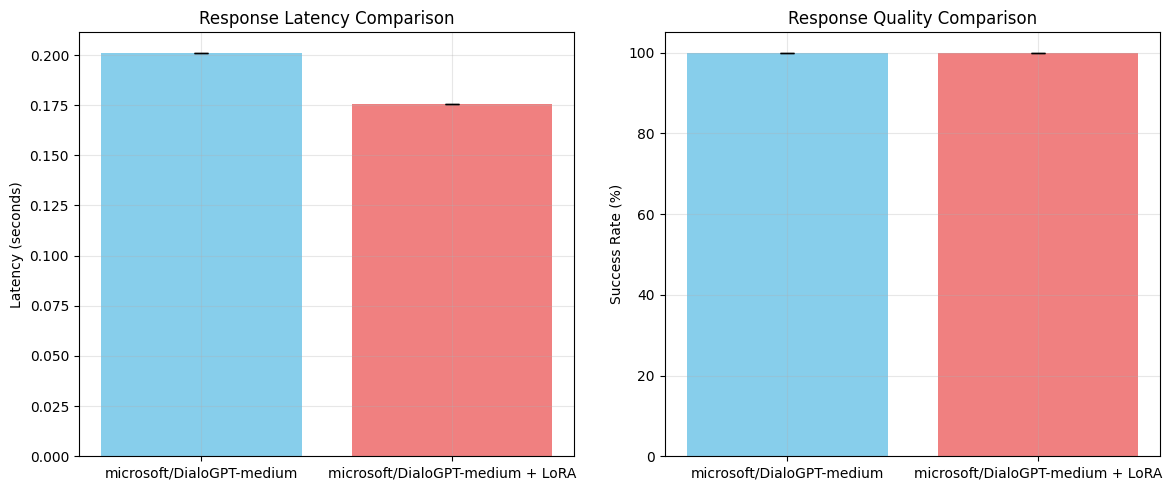

Benchmark Results Summary:
microsoft/DialoGPT-medium:
  Average Latency: 0.20s ± 0.00s
  Success Rate: 100.0% ± 0.0%
  Sample Count: 1
microsoft/DialoGPT-medium + LoRA:
  Average Latency: 0.18s ± 0.00s
  Success Rate: 100.0% ± 0.0%
  Sample Count: 1

Improvements:
  Latency: +12.7% (faster)
  Success Rate: +0.0% (worse)

💾 Memory & Parameters Analysis:
microsoft/DialoGPT-medium Model:
  Total Parameters: 354,823,168 (354.8M)
  Trainable Parameters: 354,823,168
  Model Size: 1353.5 MB
  Peak Memory: 2575.0 MB
  Avg Inference Time: 0.47s

microsoft/DialoGPT-medium + LoRA Model:
  Total Parameters: 356,985,856 (357.0M)
  Trainable Parameters: 0
  Model Size: 1361.8 MB
  Peak Memory: 2463.3 MB
  Avg Inference Time: 0.53s

Efficiency Improvements:
  Parameter Reduction: -0.6%
  Memory Reduction: +4.3%
  Latency Improvement: -11.9%
  LoRA Adapter Size: 356.986M parameters
Analysis complete using streamlined component!


In [12]:
# Analyze results using the streamlined BenchmarkAnalyzer component
from src.rag.components import get_benchmark_analyzer

# Initialize the analyzer
analyzer = get_benchmark_analyzer()

# Analyze the experiment with memory and parameter analysis
try:
    results = analyzer.analyze_experiment(
        experiment_name="lora_finetuning_benchmark",
        baseline_model_name=f"{baseline_model}",
        fine_tuned_model_name=f"{baseline_model} + LoRA",
        baseline_model_path=baseline_model,  # Add baseline model path
        adapter_path=str(model_configs_path / 'lora_adapters' / 'microsoft' / 'DialoGPT-medium' / 'lora_adapter'),  # Add adapter path
        show_plots=True,
        save_plots=False
    )
    print("Analysis complete using streamlined component!")
except Exception as e:
    print(f"Analysis failed: {e}")
    print("Falling back to inline analysis...")

## Phase 4: Implement Iterative Optimizations

Based on analysis, iterate by adjusting hyperparameters in `lora_finetuner.py`, switching models via `model_manager.py`, or enhancing data with `text_chunker.py`. Re-run phases as needed for continuous improvement.

In [ ]:
# Example optimizations
# - Increase dataset size
# - Tune hyperparameters
# - Add more data preprocessing

# Re-run training or benchmarking as needed
print("Optimizations implemented. Ready for next iteration.")